<a href="https://colab.research.google.com/github/ITEX-sites/Garibaldi/blob/main/Supervised_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

pip install rasterio


In [2]:
import rasterio as rio
import numpy as np
import geopandas as gpd
from sklearn.model_selection import train_test_split
import fiona
from rasterio.features import geometry_mask
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

from rasterio.plot import show
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from osgeo import ogr, gdal
from glob import glob
import rasterio.warp
from rasterio.enums import Resampling
import subprocess

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Preparing the raster data for model input

In [4]:
# input files
satellite2 = '/content/drive/MyDrive/PIXELS_python/Raster_stacks/sat_clip.tif'
points = '/content/drive/MyDrive/PIXELS_python/Data/training_points/training_points.shp'
temp_point_loc = '/content/drive/MyDrive/PIXELS_python/Data/empty_shp/empty.shp'
dem_path = '/content/drive/MyDrive/PIXELS_python/Data/clipped_dem.tif'

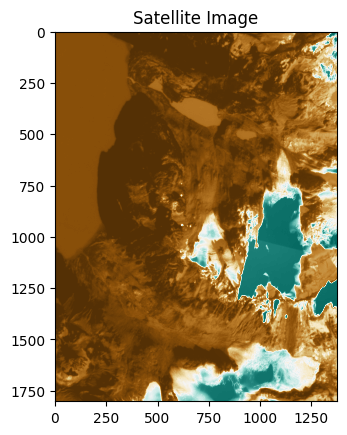

Satellite Coordinate Reference System
EPSG:32610
DEM Coordinate Reference System
EPSG:4326


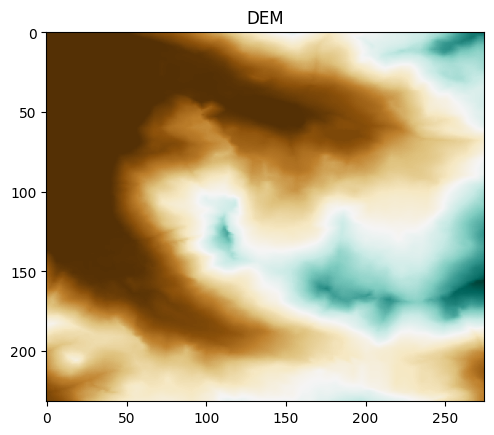

In [5]:
#Get CRS for both DEM and Sat

sat = rasterio.open(satellite2)
DEM = rasterio.open(dem_path)
DEM_src = DEM.read(1)
band1 = sat.read(1)
band2 = sat.read(2)

plt.imshow(band2, cmap = "BrBG")
plt.title("Satellite Image")
plt.show()

print("Satellite Coordinate Reference System")
sat_crs = sat.crs
print(sat_crs)

print("DEM Coordinate Reference System")
dem_crs = DEM.crs
print(dem_crs)

plt.imshow(DEM_src, cmap = "BrBG")
plt.title("DEM")
plt.show()

In [6]:
#reproject layers to match CRS of satellite imagery (or other crs)

def reproject_raster(in_path, out_path, target_crs):
    with rio.open(in_path) as src:
        transform, width, height = rio.warp.calculate_default_transform(src.crs, target_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rio.open(out_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                rio.warp.reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.nearest
                )

# assign target crs to variable, define output directory for reprojected layers
target_crs = 'EPSG:32610'
output_dem = "/content/drive/MyDrive/PIXELS_python/Data/reprojected_DEM.tif"

# Reproject the slope, tpi, and any other rasters used as model input
reproject_raster(dem_path, output_dem, target_crs)

#reassign variables
dem_path = output_dem

DEM = rasterio.open(dem_path)
print("DEM Coordinate Reference System")
dem_crs = DEM.crs
print(dem_crs)

DEM Coordinate Reference System
EPSG:32610


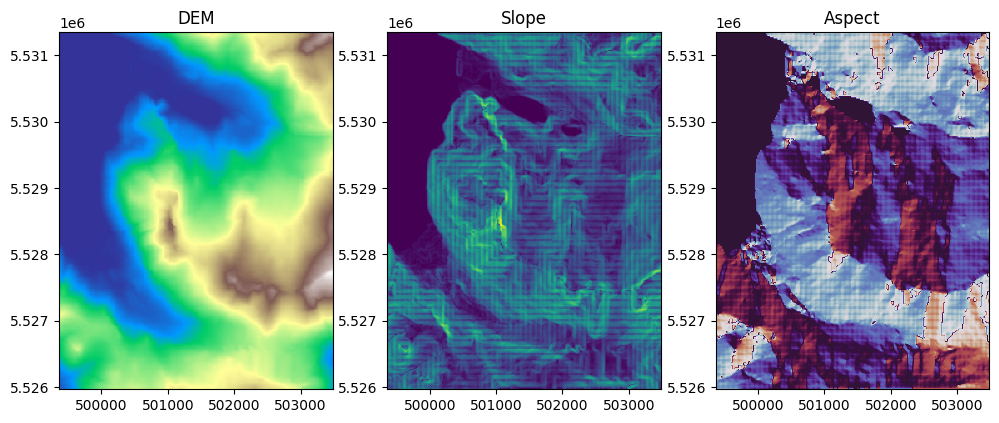

In [7]:
#Creating Slope and Aspect Rasters from the DEM

slope_output_path = '/content/drive/MyDrive/PIXELS_python/Data/slope.tif'
aspect_output_path = '/content/drive/MyDrive/PIXELS_python/Data/aspect.tif'

# Open the DEM raster
with rasterio.open(dem_path) as dem_src:
    # Read the DEM data as a numpy array
    dem = dem_src.read(1)

    # Calculate slope using numpy.gradient
    slope_x, slope_y = np.gradient(dem_src.read(1), dem_src.res[0], dem_src.res[1])
    slope = np.arctan(np.sqrt(slope_x**2 + slope_y**2))

    # Calculate aspect using numpy.arctan2
    aspect = np.arctan2(-slope_y, slope_x)

     # Save the slope as a new raster
    with rasterio.open(
        slope_output_path,
        'w',
        driver='GTiff',
        width=dem_src.width,
        height=dem_src.height,
        count=1,
        dtype=slope.dtype,
        crs=dem_src.crs,
        transform=dem_src.transform,
    ) as slope_dst:
        slope_dst.write(slope, 1)

     # Save the aspect as a new raster
    with rasterio.open(
        aspect_output_path,
        'w',
        driver='GTiff',
        width=dem_src.width,
        height=dem_src.height,
        count=1,
        dtype=aspect.dtype,
        crs=dem_src.crs,
        transform=dem_src.transform,
    ) as aspect_dst:
        aspect_dst.write(aspect, 1)

# Convert aspect values to degrees
aspect = np.degrees(aspect)

#Plotting the rasters
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(dem, cmap='terrain', extent=rasterio.plot.plotting_extent(dem_src))
plt.title('DEM')

plt.subplot(1, 3, 2)
plt.imshow(slope, cmap='viridis', extent=rasterio.plot.plotting_extent(dem_src))
plt.title('Slope')

plt.subplot(1, 3, 3)
plt.imshow(aspect, cmap='twilight', extent=rasterio.plot.plotting_extent(dem_src))
plt.title('Aspect')

plt.show()

slope_path = slope_output_path
aspect_path = aspect_output_path

# Normalizing Rasters

1001.9724190905449


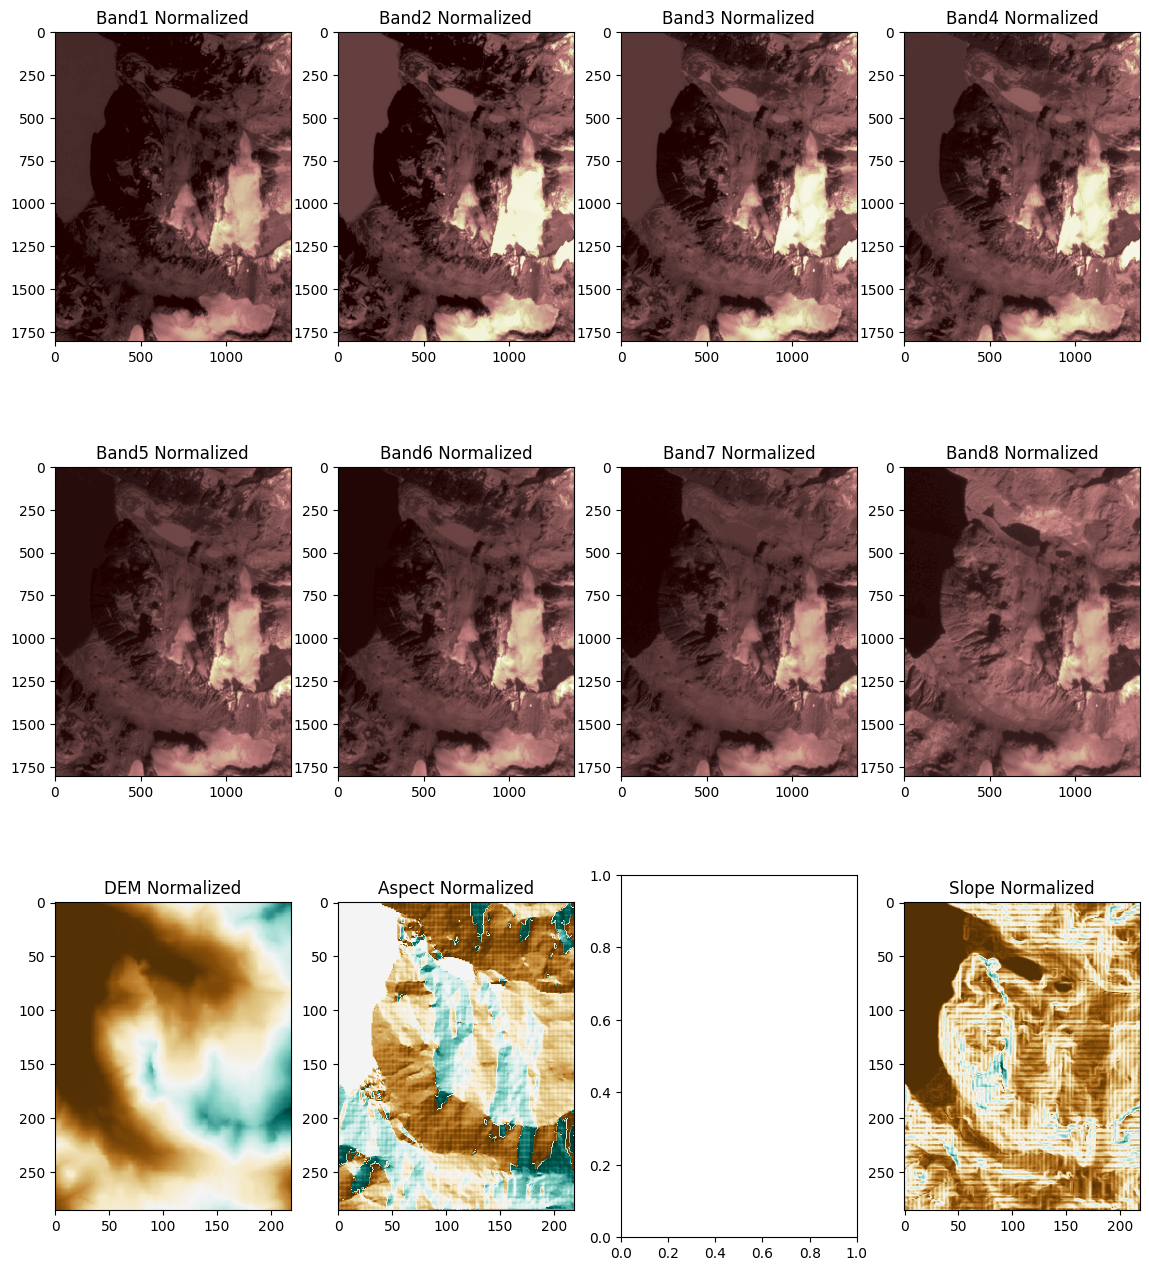

In [8]:
row_num = 3
colum_num = 4

#assigning each band to a variable and normalizing raster layer using standard normalization
with rio.open(satellite2) as sat:
  band1 = sat.read(1)
  band1_mean_pixel = np.mean(band1)
  band1_normalized = band1 / band1_mean_pixel
  print(band1_mean_pixel)

  band2 = sat.read(2)
  band2_mean_pixel = np.mean(band2)
  band2_minus_mean = band2 - band2_mean_pixel
  band2_std = np.std(band2_minus_mean)
  band2_normalized = band2_minus_mean / band2_std

  band3 = sat.read(3)
  band3_mean_pixel = np.mean(band3)
  band3_minus_mean = band3 - band3_mean_pixel
  band3_std = np.std(band3_minus_mean)
  band3_normalized = band3_minus_mean / band3_std

  band4 = sat.read(4)
  band4_mean_pixel = np.mean(band4)
  band4_minus_mean = band4 - band4_mean_pixel
  band4_std = np.std(band4_minus_mean)
  band4_normalized = band4_minus_mean / band4_std

  band5 = sat.read(5)
  band5_mean_pixel = np.mean(band5)
  band5_minus_mean = band5 - band5_mean_pixel
  band5_std = np.std(band5)
  band5_normalized = band5_minus_mean / band5_std

  band6 = sat.read(6)
  band6_mean_pixel = np.mean(band6)
  band6_minus_mean = band6 - band6_mean_pixel
  band6_std = np.std(band6)
  band6_normalized = band6_minus_mean / band6_std

  band7 = sat.read(7)
  band7_mean_pixel = np.mean(band7)
  band7_minus_mean = band7 - band7_mean_pixel
  band7_std = np.std(band7)
  band7_normalized = band7_minus_mean / band7_std

  band8 = sat.read(8)
  band8_mean_pixel = np.mean(band8)
  band8_minus_mean = band8 - band8_mean_pixel
  band8_std = np.std(band8)
  band8_normalized = band8_minus_mean / band8_std

  fig, ax = plt.subplots(row_num, colum_num, figsize=(14,16))
  plt.subplot(row_num, colum_num, 1)
  plt.imshow(band1_normalized, cmap='pink')
  plt.title('Band1 Normalized')
  plt.subplot(row_num, colum_num, 2)
  plt.imshow(band2_normalized, cmap='pink')
  plt.title('Band2 Normalized')
  plt.subplot(row_num, colum_num, 3)
  plt.imshow(band3_normalized, cmap='pink')
  plt.title('Band3 Normalized')
  plt.subplot(row_num, colum_num, 4)
  plt.imshow(band4_normalized, cmap='pink')
  plt.title('Band4 Normalized')
  plt.subplot(row_num, colum_num, 5)
  plt.imshow(band5_normalized, cmap='pink')
  plt.title('Band5 Normalized')
  plt.subplot(row_num, colum_num, 6)
  plt.imshow(band6_normalized, cmap='pink')
  plt.title('Band6 Normalized')
  plt.subplot(row_num, colum_num, 7)
  plt.imshow(band7_normalized, cmap='pink')
  plt.title('Band7 Normalized')
  plt.subplot(row_num, colum_num, 8)
  plt.imshow(band8_normalized, cmap='pink')
  plt.title('Band8 Normalized')

with rio.open(dem_path) as dem:
  DEM = dem.read(1)
  dem_mean_pixel = np.mean(DEM)
  dem_normalized = DEM / dem_mean_pixel
  plt.subplot(row_num, colum_num, 9)
  plt.imshow(DEM, cmap='BrBG')
  plt.title("DEM Normalized")

with rio.open(aspect_path) as asp:
  aspect = asp.read(1)
  aspect_mean_pixel = np.mean(aspect)
  aspect_normalized = aspect / aspect_mean_pixel
  plt.subplot(row_num, colum_num, 10)
  plt.imshow(aspect, cmap='BrBG')
  plt.title("Aspect Normalized")

#with rio.open(tpi_path) as tpi:
#  TPI = tpi.read(1)
#  tpi_mean_pixel = np.mean(TPI)
#  print(tpi_mean_pixel)
#  plt.subplot(row_num, colum_num, 11)
#  plt.imshow(TPI, cmap='BrBG')

with rio.open(slope_path) as slp:
  slope = slp.read(1)
  slope_mean_pixel = np.mean(slope)
  slope_normalized = slope / slope_mean_pixel
  plt.subplot(row_num, colum_num, 12)
  plt.imshow(slope, cmap='BrBG')
  plt.title('Slope Normalized')


In [9]:
#saving normalized rasters
aspect_norm_path = '/content/drive/MyDrive/PIXELS_python/Data/aspect_norm.tif'
dem_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/dem_norm.tif'
slope_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/slope_norm.tif'
band1_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/band1_norm.tif'
band2_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/band2_norm.tif'
band3_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/band3_norm.tif'
band4_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/band4_norm.tif'
band5_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/band5_norm.tif'
band6_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/band6_norm.tif'
band7_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/band7_norm.tif'
band8_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/band8_norm.tif'

#DEM
with rasterio.open(
    dem_norm_path,
    'w',
    driver='GTiff',
    width=dem_src.width,
    height=dem_src.height,
    count=1,
    dtype=DEM.dtype,
    crs=dem_src.crs,
    transform=dem_src.transform,
    ) as dem_norm:
    dem_norm.write(dem_normalized, 1)

#aspect
with rasterio.open(
    aspect_norm_path,
    'w',
    driver='GTiff',
    width=dem_src.width,
    height=dem_src.height,
    count=1,
    dtype=aspect.dtype,
    crs=dem_src.crs,
    transform=dem_src.transform,
    ) as aspect_norm:
    aspect_norm.write(aspect_normalized, 1)

#slope
with rasterio.open(
    slope_norm_path,
    'w',
    driver='GTiff',
    width=dem_src.width,
    height=dem_src.height,
    count=1,
    dtype=slope.dtype,
    crs=dem_src.crs,
    transform=dem_src.transform,
    ) as slope_norm:
    slope_norm.write(slope_normalized, 1)

## function to save sat bands because they have the same transform and resolution
def saving_sat(out_path, band_name):
  with rasterio.open(
    out_path,
    'w',
    driver='GTiff',
    width=sat.width,
    height=sat.height,
    count=1,
    dtype=band1.dtype,
    crs=sat.crs,
    transform=sat.transform,
    ) as sat_norm:
    sat_norm.write(band_name, 1)

saving_sat(band1_norm_path, band1_normalized)
saving_sat(band2_norm_path, band2_normalized)
saving_sat(band3_norm_path, band3_normalized)
saving_sat(band4_norm_path, band4_normalized)
saving_sat(band5_norm_path, band5_normalized)
saving_sat(band6_norm_path, band6_normalized)
saving_sat(band7_norm_path, band7_normalized)
saving_sat(band8_norm_path, band8_normalized)

In [10]:
#stacking rasters

input_rasters = [band1_norm_path, band2_norm_path, band3_norm_path, band4_norm_path, band5_norm_path, band6_norm_path,
                 band7_norm_path, band8_norm_path, dem_norm_path, slope_norm_path, aspect_norm_path]
output_stack = "/content/drive/MyDrive/PIXELS_python/Data/stacked_trial.tif"

gdal_cmd1 = ['gdal_merge.py', '-o', output_stack, '-separate'] + input_rasters

subprocess.run(gdal_cmd1)

stacked = output_stack

#Training The Model

In [ ]:
#reading the shapefile with training data as points as a geodataframe (gdf
points = gpd.read_file(points)

# adding a new column 'id'
points = points.assign(id=range(len(points)))
# saving new empty shapefile with 'id' column
points.to_file(temp_point_loc)
# converting gdf to dataframe (df) and removing geometry
points_df = pd.DataFrame(points.drop(columns='geometry'))


In [ ]:
# reading bands from input, returns how many
with rio.open(stacked) as img:
    bands = img.count
    print('PSScene bands: ', bands) #the satellite imagery I used is PlanetScope PSScene product

#creates list of band names from image
features = []
for i in range(bands):
    features.append('band'+str(i+1))
print('Bands names: ', features)
f_len = len(features)

In [ ]:
# ilterating over multiband raster
sampled = pd.Series()

#inputShape= temp_point_loc
# Read input shapefile with fiona and iterate over each feature
with fiona.open(temp_point_loc) as shp:
    for feature in shp:
        siteID = feature['properties']['num_class']
        coords = feature['geometry']['coordinates']
        # Read pixel value at the given coordinates using Rasterio
        # NB: `sample()` returns an iterable of ndarrays.
        with rio.open(stacked) as stack_src:
                  value = [v for v in stack_src.sample([coords])]
        # Update the pandas serie accordingly
        sampled.loc[siteID] = value

# reshaping sampled values
df1 = pd.DataFrame(sampled.values.tolist(), index=sampled.index)
df1['num_class'] = df1.index
df1 = pd.DataFrame(df1[0].values.tolist(),
                   columns=features)
df1['num_class'] = df1.index

data = pd.merge(df1, points_df, on ='num_class')
print('Sampled Data: \n',data)

In [ ]:
# ilterating over multiband raster
sampled = pd.Series()

#inputShape= temp_point_loc
# Read input shapefile with fiona and iterate over each feature
with fiona.open(temp_point_loc) as shp:
    for feature in shp:
        siteID = feature['properties']['num_class']
        coords = feature['geometry']['coordinates']
        # Read pixel value at the given coordinates using Rasterio
        # NB: `sample()` returns an iterable of ndarrays.
        with rio.open(stacked) as stack_src:
                  value = [v for v in stack_src.sample([coords])]
        # Update the pandas serie accordingly
        sampled.loc[siteID] = value

# reshaping sampled values
df1 = pd.DataFrame(sampled.values.tolist(), index=sampled.index)
df1['num_class'] = df1.index
df1 = pd.DataFrame(df1[0].values.tolist(),
                   columns=features)
df1['num_class'] = df1.index

data = pd.merge(df1, points_df, on ='num_class')
print('Sampled Data: \n',data)

In [ ]:
x = data.iloc[:,0:f_len]
X = x.values
y = data.iloc[:,-2]
Y = y.values

print(X)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, stratify = Y)

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
cName = 'SVM'
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)

clf_pred = clf.predict(X_test)

print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*100}")
print(classification_report(y_test, clf_pred))


In [ ]:
#confusion matrix

cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = (100 * (cm/np.sum(cm)))

print(cm_percent)

In [ ]:
%%time
cName = 'SVM'
exp_name = f'/content/drive/MyDrive/PIXELS_python/Data{cName}.tif'


img = rio.open(stacked)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, f_len)
print('reshaped full data shape  for prediction: ',img_n.shape)
metadata = img.meta
height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')

In [ ]:
pred_full = clf.predict(img_n)

print('Prediction Done, now exporting raster \n')

img_reshape = pred_full.reshape(height, width)


out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1, # output band number
                                          dtype='uint8', #output data type
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()